In [1]:
file_path =r"C:\Users\ricca\Documents\PhD\Potentials\SI_cif.txt.txt"

with open(file_path, "r") as cif:
    lines = cif.readlines()
a = lines[lines.index("_cell_length_a 6.636"+"\n")].split()[1]
matchers = ["_cell_length_a", "_cell_length_b", "_cell_length_c", "_cell_angle_alpha", "_cell_angle_beta", "_cell_angle_gamma"]
values = [line for line in lines if any(matcher in line for matcher in matchers)]#[0].split()[1]
a, b, c, alfa, beta, gamma = [float(element.split()[1]) for element in values]
#queste variabili sono grà trasformate in numero

###################### ORA TOCCA AI VETTORI #######################################

vectors = []
for i, line in enumerate(lines):
    if line.startswith("_space_group_symop_operation_xyz"):
        for j in range(i + 1, len(lines)):
            if lines[j].startswith("loop_"):
                break
            elif lines[j].startswith(" "):
                vectors.append(lines[j].strip())
print(vectors)
vectors = [vector.strip("'").split(",") for vector in vectors] # remove '
print(vectors)

for vector in vectors:
    for i in range(len(vector)):
        vector[i]= vector[i].replace("x", str(a))
        vector[i]= vector[i].replace("y", str(b))
        vector[i]= vector[i].replace("z", str(c))
print(vectors)

["'x,y,z'", "'1/2+x,1/2+y,1/2+z'", "'1/2+z,x,1/2-y'", "'+z,1/2+x,-y'", "'1/2+z,-x,y'", "'+z,1/2-x,1/2+y'", "'-z,x,1/2+y'", "'1/2-z,1/2+x,+y'", "'-z,-x,-y'", "'1/2-z,1/2-x,1/2-y'", "'1/2+y,1/2-z,-x'", "'+y,-z,1/2-x'", "'-y,1/2-z,x'", "'1/2-y,-z,1/2+x'", "'1/2-y,z,-x'", "'-y,1/2+z,1/2-x'", "'y,z,x'", "'1/2+y,1/2+z,1/2+x'", "'x,1/2-y,1/2+z'", "'1/2+x,-y,+z'", "'-x,y,1/2+z'", "'1/2-x,1/2+y,+z'", "'x,1/2+y,-z'", "'1/2+x,+y,1/2-z'", "'-x,-y,-z'", "'1/2-x,1/2-y,1/2-z'", "'1/2-z,-x,1/2+y'", "'-z,1/2-x,+y'", "'1/2-z,x,-y'", "'-z,1/2+x,1/2-y'", "'z,-x,1/2-y'", "'1/2+z,1/2-x,-y'", "'z,x,y'", "'1/2+z,1/2+x,1/2+y'", "'1/2-y,1/2+z,x'", "'-y,+z,1/2+x'", "'y,1/2+z,-x'", "'1/2+y,+z,1/2-x'", "'1/2+y,-z,x'", "'+y,1/2-z,1/2+x'", "'-y,-z,-x'", "'1/2-y,1/2-z,1/2-x'", "'-x,1/2+y,1/2-z'", "'1/2-x,+y,-z'", "'x,-y,1/2-z'", "'1/2+x,1/2-y,-z'", "'-x,1/2-y,z'", "'1/2-x,-y,1/2+z'"]
[['x', 'y', 'z'], ['1/2+x', '1/2+y', '1/2+z'], ['1/2+z', 'x', '1/2-y'], ['+z', '1/2+x', '-y'], ['1/2+z', '-x', 'y'], ['+z', '1/2-x', '1

In [ ]:
'''###Nicola's code
# Carica la struttura dal file CIF
structure = Structure.from_file("AMS_DATA (1).cif")
# structure = SiteCollection.from_file("AMS_DATA.cif")
print(structure)
supercell = structure.make_supercell([2,2,2])
print(structure)

# print(structure)
# Specifica il piano di interesse (ad esempio: x = 0)
plane = cgu.Plane.from_coefficients(1,0,0,0)
# print(plane)

# Trova gli atomi nella posizione del piano di interesse
tolerance = 1e-10
atoms_in_plane = []
positions =[]
for site in structure:
    # print(site)
    # if plane.is_in_plane(site,tolerance):
        # print (site)
        # atoms_in_plane.append(site)
    dist = float(plane.distance_to_point(site.coords))
    # positions.append(site.coords)
    # print(positions)
    # print(dist, " - ", tolerance)
    # print ("d-t ", dist-tolerance)
    if abs(dist) <= tolerance:
        # print(site)
        atoms_in_plane.append(site.coords)


for atoms in atoms_in_plane:
    print (atoms)
    positions.append(list(atoms))
    # print(type(atoms))
# print(atoms_in_plane)
print(positions)
# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()'''

# CODICE STRUTTURA

## Parte 1

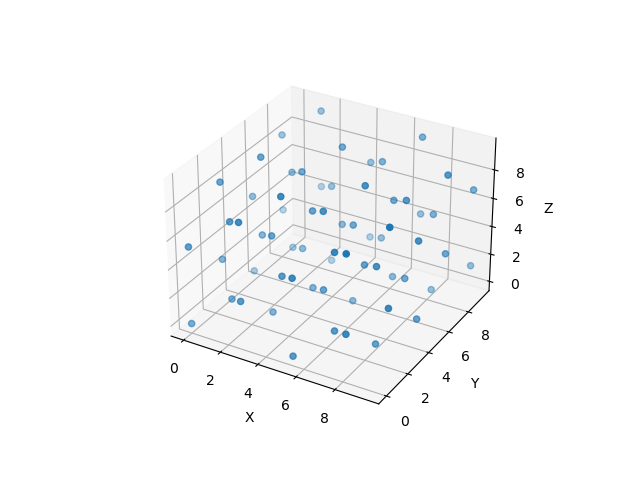

In [109]:
%matplotlib widget
from pymatgen.core import Structure
from pymatgen.analysis.chemenv.utils import coordination_geometry_utils as cgu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Caricamento della struttura cristallina del silicio
path_cif = r"C:\Users\ricca\Downloads\AMS_DATA (1).cif"
structure = Structure.from_file(path_cif)

# Replicazione della cella unitaria per ottenere una cella superiore
supercell = structure.make_supercell([2, 2, 2])

# Estrazione delle posizioni degli atomi
positions = structure.cart_coords

# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [110]:
'''path_cif = r"C:\Users\ricca\Downloads\AMS_DATA (1).cif"

# Carica la struttura dal file CIF
structure = Structure.from_file(path_cif)
# print(structure)
# Specifica il piano di interesse (ad esempio: x = 0)
plane = cgu.Plane.from_coefficients(1,0,0,0)
# print(plane)

# Trova gli atomi nella posizione del piano di interesse
tolerance = 1.0
atoms_in_plane = []
for site in structure:
    # print(site)
    # if plane.is_in_plane(site,tolerance):
        # print (site)
        # atoms_in_plane.append(site)
    dist = float(plane.distance_to_point(site.coords))
    print(site.coords)
    # print(dist, " - ", tolerance)
    # print ("d-t ", dist-tolerance)
    if abs(dist) < tolerance:
        # print(site)
        atoms_in_plane.append(site)



print(atoms_in_plane)'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 15-16: truncated \UXXXXXXXX escape (2784526256.py, line 28)

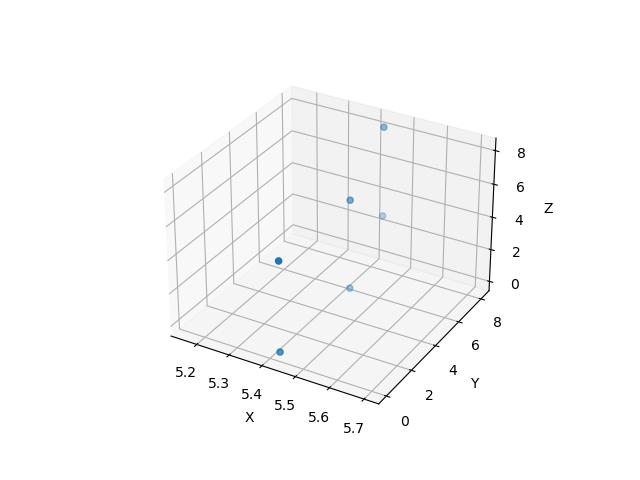

In [111]:
#chatgpt code for plane intersection
# Estrazione delle posizioni degli atomi sul piano (1 0 0)
positions = []
for site in structure:
    if site.frac_coords[0] == 0.5:  # controlla se il primo coordinata del sito è 0.5
        positions.append(site.coords)

# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter([p[0] for p in positions], [p[1] for p in positions], [p[2] for p in positions])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

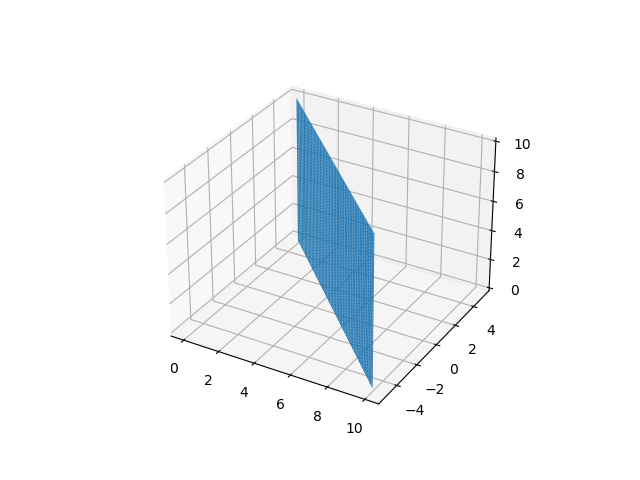

No such comm: 2a133ebf6b374fea963ae3b466abf5f0


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xs = np.linspace(0, 10, 100)
zs = np.linspace(0, 10, 100)

X,Z = np.meshgrid(xs, zs)
Y = 5-X

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,Z)
plt.show()

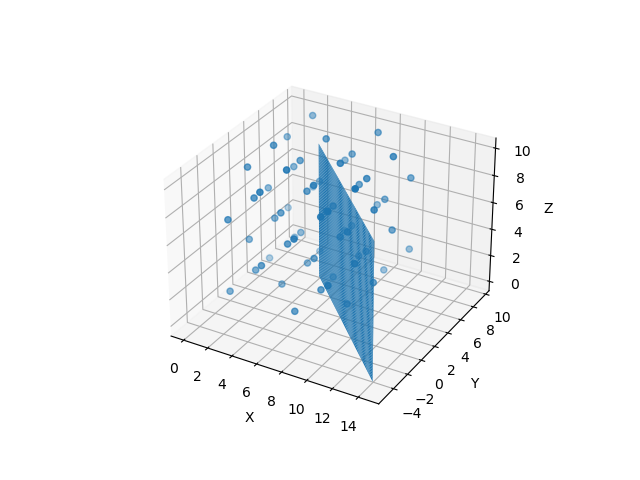

In [113]:
%matplotlib widget
from pymatgen.core import Structure
from pymatgen.analysis.chemenv.utils import coordination_geometry_utils as cgu
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Caricamento della struttura cristallina del silicio
path_cif = r"C:\Users\ricca\Downloads\AMS_DATA (1).cif"
structure = Structure.from_file(path_cif)

# Replicazione della cella unitaria per ottenere una cella superiore
supercell = structure.make_supercell([2, 2, 2])

# Estrazione delle posizioni degli atomi
positions = structure.cart_coords

### piano
x = positions[:,0].max()
#x = positions[:,0].min()
# Definiamo il vettore perpendicolare al piano e un punto del piano
normal_vector = np.array([1, 1, 0])
point_on_plane = np.array([x/2, x/2, x/2])

# Calcoliamo il valore di D utilizzando la formula del piano
D = -np.dot(normal_vector, point_on_plane)
y = np.linspace(-5, 5, 100)
z = np.linspace(-5, 5, 100)
X = (-normal_vector[1]*Y - normal_vector[2]*Z - D)/(normal_vector[0])

# Plot delle posizioni degli atomi nello spazio 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[:,0], positions[:,1], positions[:,2])
ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()



In [ ]:
print(positions)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.43070000e+00]
 [8.73323167e-16 5.43070000e+00 3.32534469e-16]
 [8.73323167e-16 5.43070000e+00 5.43070000e+00]
 [5.43070000e+00 0.00000000e+00 3.32534469e-16]
 [5.43070000e+00 0.00000000e+00 5.43070000e+00]
 [5.43070000e+00 5.43070000e+00 6.65068937e-16]
 [5.43070000e+00 5.43070000e+00 5.43070000e+00]
 [4.36661584e-16 2.71535000e+00 2.71535000e+00]
 [4.36661584e-16 2.71535000e+00 8.14605000e+00]
 [1.30998475e-15 8.14605000e+00 2.71535000e+00]
 [1.30998475e-15 8.14605000e+00 8.14605000e+00]
 [5.43070000e+00 2.71535000e+00 2.71535000e+00]
 [5.43070000e+00 2.71535000e+00 8.14605000e+00]
 [5.43070000e+00 8.14605000e+00 2.71535000e+00]
 [5.43070000e+00 8.14605000e+00 8.14605000e+00]
 [2.71535000e+00 0.00000000e+00 2.71535000e+00]
 [2.71535000e+00 0.00000000e+00 8.14605000e+00]
 [2.71535000e+00 5.43070000e+00 2.71535000e+00]
 [2.71535000e+00 5.43070000e+00 8.14605000e+00]
 [8.14605000e+00 0.00000000e+00 2.715350

In [176]:
'''posizioni_proiezioni = []
for vettore_posizione in vettori_posizione:
    prodotto_scalare = np.dot(vettore_posizione, vettore_normale)
    posizione_proiezione = prodotto_scalare / lunghezza_normale
    posizione_proiezione_vettoriale = np.array(vettore_posizione) - (posizione_proiezione * np.array(vettore_normale))
    posizioni_proiezioni.append(posizione_proiezione_vettoriale)'''

asse = r"1 1 0"
norm_vector = (1, 0, 0)
norma = np.linalg.norm(norm_vector)

norm_vector = norm_vector/norma
#print(norma)
vector_projections = []
for position in positions:
    pr_scalar = np.dot(position, norm_vector) * norm_vector
    print(" position", position)
    print(" pr_scalar", pr_scalar)
    #projection = pr_scalar/norma
    vector_projection = np.array(position) - (pr_scalar) # projection *
    vector_projections.append(vector_projection)

print(vector_projections)


 position [0. 0. 0.]
 pr_scalar [0. 0. 0.]
 position [0.     0.     5.4307]
 pr_scalar [0. 0. 0.]
 position [8.73323167e-16 5.43070000e+00 3.32534469e-16]
 pr_scalar [8.73323167e-16 0.00000000e+00 0.00000000e+00]
 position [8.73323167e-16 5.43070000e+00 5.43070000e+00]
 pr_scalar [8.73323167e-16 0.00000000e+00 0.00000000e+00]
 position [5.43070000e+00 0.00000000e+00 3.32534469e-16]
 pr_scalar [5.4307 0.     0.    ]
 position [5.4307 0.     5.4307]
 pr_scalar [5.4307 0.     0.    ]
 position [5.43070000e+00 5.43070000e+00 6.65068937e-16]
 pr_scalar [5.4307 0.     0.    ]
 position [5.4307 5.4307 5.4307]
 pr_scalar [5.4307 0.     0.    ]
 position [4.36661584e-16 2.71535000e+00 2.71535000e+00]
 pr_scalar [4.36661584e-16 0.00000000e+00 0.00000000e+00]
 position [4.36661584e-16 2.71535000e+00 8.14605000e+00]
 pr_scalar [4.36661584e-16 0.00000000e+00 0.00000000e+00]
 position [1.30998475e-15 8.14605000e+00 2.71535000e+00]
 pr_scalar [1.30998475e-15 0.00000000e+00 0.00000000e+00]
 position [

[0. 0. 0.]
[0.     0.     5.4307]
[0.     5.4307 0.    ]
[0.     5.4307 5.4307]
[0. 0. 0.]
[0.     0.     5.4307]
[0.     5.4307 0.    ]
[0.     5.4307 5.4307]
[0.      2.71535 2.71535]
[0.      2.71535 8.14605]


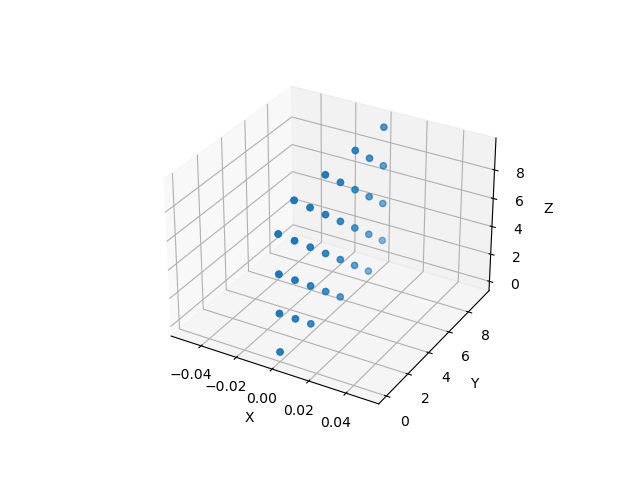

In [177]:
soglia = 1e-10
for prj in vector_projections: #to make all np.arrays
    # print (atoms)
    prj[np.abs(prj)< soglia] = 0.0
    #print(prj)
#print(vector_projections)
ndarray_projs = np.array(vector_projections)
for i in range(0,10):
    print(ndarray_projs[i])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ndarray_projs[:,0], ndarray_projs[:,1], ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
theta = np.radians(0)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c, -s, 0), (s, c, 0), (0, 0, 1)))
print(R)

r_ndarray_projs = []
for p in ndarray_projs:
    r_ndarray_proj = np.dot(R, p)
    #print("rotated",r_ndarray_proj)
    r_ndarray_projs.append(r_ndarray_proj)
    
for prj in r_ndarray_projs: #to make all np.arrays
    # print (atoms)
    prj[np.abs(prj)< soglia] = 0.0

r_ndarray_projs = np.array(r_ndarray_projs)
print(r_ndarray_projs)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r_ndarray_projs[:,0], r_ndarray_projs[:,1], r_ndarray_projs[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

In [171]:
x_positions = []
y_positions = []
atom_positions = []
for a in range(0,len(r_ndarray_projs)):
    atom_positions.append((round(r_ndarray_projs[a][0],3),round(r_ndarray_projs[a][2],3)))
    x_positions.append(round(r_ndarray_projs[a][0],3))
    y_positions.append(round(r_ndarray_projs[a][2],3))
print(atom_positions)
atom_positions = list(set(atom_positions))
print("at_pos", atom_positions)
print(len(atom_positions))
print(type(atom_positions))

for atom in atom_positions:
    if atom[0]==0.0:
        print(atom)

[(0.0, 0.0), (0.0, 5.431), (-3.84, 0.0), (-3.84, 5.431), (3.84, 0.0), (3.84, 5.431), (0.0, 0.0), (0.0, 5.431), (-1.92, 2.715), (-1.92, 8.146), (-5.76, 2.715), (-5.76, 8.146), (1.92, 2.715), (1.92, 8.146), (-1.92, 2.715), (-1.92, 8.146), (1.92, 2.715), (1.92, 8.146), (-1.92, 2.715), (-1.92, 8.146), (5.76, 2.715), (5.76, 8.146), (1.92, 2.715), (1.92, 8.146), (0.0, 0.0), (0.0, 5.431), (-3.84, 0.0), (-3.84, 5.431), (3.84, 0.0), (3.84, 5.431), (0.0, 0.0), (0.0, 5.431), (0.0, 1.358), (0.0, 6.788), (-3.84, 1.358), (-3.84, 6.788), (3.84, 1.358), (3.84, 6.788), (0.0, 1.358), (0.0, 6.788), (1.92, 4.073), (1.92, 9.504), (-1.92, 4.073), (-1.92, 9.504), (5.76, 4.073), (5.76, 9.504), (1.92, 4.073), (1.92, 9.504), (-1.92, 4.073), (-1.92, 9.504), (-5.76, 4.073), (-5.76, 9.504), (1.92, 4.073), (1.92, 9.504), (-1.92, 4.073), (-1.92, 9.504), (0.0, 1.358), (0.0, 6.788), (-3.84, 1.358), (-3.84, 6.788), (3.84, 1.358), (3.84, 6.788), (0.0, 1.358), (0.0, 6.788)]
at_pos [(1.92, 4.073), (-1.92, 4.073), (5.76, 8

In [174]:
a_Si = [1.876, 2.617, 0.8604, 0.3903, 0.07769 ]
b_Si = [62.11, 18.68, 3.935, 0.7690, 0.0823]
a_err_Si = 0.5067 * 10**(-3)
B_Si = [b/(4*(np.pi)**(2)) for b in b_Si]

alfa = [0.1, 0.55, 0.35]
beta = [6.0, 1.2, 0.3]

u_1 = 0.075 #preso da sytov thesis
z = 1
a_0 = 0.53 #Angstrom
e = 1.6E-19
N = 4.995E-2 #atomic concentration
Z = 14
d_pl = 1.36 #(100)
d_at = 5.43 #<100>
a_TF = (9*np.pi**2/(128*Z))**(1/3)*a_0

def U_DT_2D(x, y, x_0, y_0): 
    U1 = 2/d_at*Z*z*e*a_0
    k1 = [(a_Si[i]/np.sqrt(B_Si[i]+2*u_1**2))*np.exp(-((x-x_0)**2+(y-y_0)**2)/(B_Si[i]+2*u_1**2)) for i in range(0,len(a_Si))]
    k = sum(k1)
    return U1*k

nat = 2
d = d_at/(2*np.sqrt(2))
# Definisci il range di x e y
x = np.linspace(min(x_positions), max(x_positions), 1000)
y = np.linspace(min(y_positions), max(y_positions), 1000)
xx, yy = np.meshgrid(x, y)

x_0 = [0] * 100
y_0 = [0] * 100
xx_0, yy_0 = np.meshgrid(x_0,y_0)

U_2D= np.zeros_like(xx)
for atom in atom_positions:
    U_2D += U_DT_2D(xx,yy,atom[0],atom[1])/e
    #print(x_positions[i],y_positions[i])
    #print(U_2D)
#print(len(U_2D))
#U_2D_s = np.sum(U_2D, axis=0)
U_max, U_min = [], []
for U in U_2D:
    U_max.append(max(U))
    U_min.append(min(U))
    
U_top, U_bottom = max(U_max), min(U_min)
print(U_top, U_bottom)
#U_2D = np.array([U_DT_2D(xx+j*d, yy+j*d) for j in range(-nat, nat)])
#print(U_2D_sum.shape)
#print(U_2D)
#U_2D_sum = sum(U_2D)/e
#U_2D_s = U_2D_s - min(U_2D_s)

#n = 20
#levels = [i*(U_2D_s.max()-U_2D_s.min())/n for i in range (0, n)]
#levels = np.linspace(4, 32, 100)


31.101780680824376 0.566048117877201


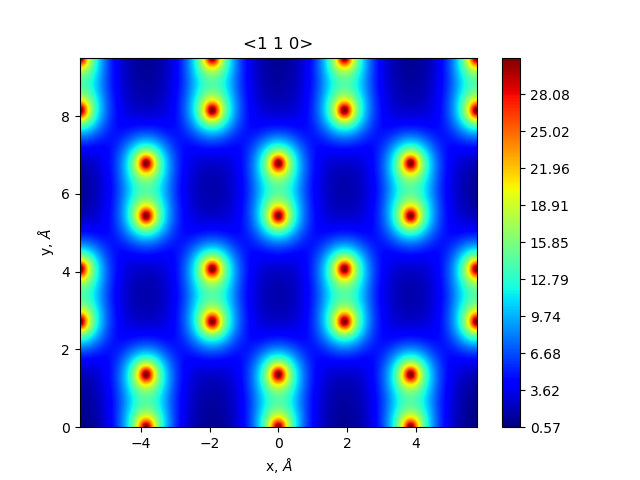

In [175]:
# Crea il grafico
levels = np.linspace(U_bottom, U_top, 1000)
fig, ax=plt.subplots()
plt.contourf(xx, yy, U_2D,levels,  cmap='jet') #levels,
plt.colorbar()
plt.title("<"+ asse +">") 
plt.xlabel('x, $\AA$')
plt.ylabel('y, $\AA$')
plt.show()